
# **Price Drop, Passenger Takeoff? Investigating Airfare Elasticity in U.S. Domestic Travel**

##### by Charlélie Brun, Janina Spielkamp & Océane Carrillo



There’s a moment we all know too well.

You’re not planning a trip. You’re not even thinking about a trip. Then suddenly, **BAM**, a **€49 flight to Miami** pops up on your screen.

> “You could be on a beach next week.”

And just like that, your mind shifts from **“no trip”** to **“maybe I should go.”**  
But what exactly made that happen? Did the lower price *cause* you to consider flying, or were you already leaning toward taking a trip anyway?

This seemingly simple behavioral response lies at the heart of what economists call the **price elasticity of demand**: the extent to which consumers adjust their behavior when prices change.

For airlines, this elasticity shapes **pricing strategies** and **revenue management**. For governments, it determines the effectiveness of **taxes** and **subsidies**. For climate policy, it is particularly central, as air travel is one of the fastest-growing sources of greenhouse gas emissions worldwide.

While aviation currently accounts for approximately **2.5–3% of global greenhouse gas emissions** ([Our World in Data](https://ourworldindata.org/global-aviation-emissions); [BAFU](https://www.bafu.admin.ch/en/greenhouse-gas-emissions-from-aviation-2)), it is also one of the fastest-growing sources of emissions. Studies show that as passenger air travel has expanded rapidly over the last few decades, it has become a significant contributor to global carbon emissions. If this growth continues unchecked, the aviation sector’s share of global emissions is expected to rise even further—especially as airfares become more affordable and travel demand increases.

Yet despite the scale of air travel, we still lack a clean causal answer. Existing studies suggest that a **10% increase in ticket prices** is associated with a **5–8% drop in passenger numbers**, but these estimates vary widely across routes, time periods, and empirical approaches.

The core difficulty is simple: **prices and demand move together**. Airlines raise prices when they expect strong demand, and passengers adjust demand when they anticipate price changes. Untangling cause from effect is therefore far from straightforward.

In this project, we study this challenge in a concrete setting: **U.S. domestic air travel from the mid-1990s to 2025**. Using detailed route-level data, we examine how passenger demand responds to price changes as we progressively refine the empirical lens—moving from simple correlations to more careful causal strategies.

Before turning to the analysis, however, we need to step back and map the terrain in which prices and passengers interact.


# 1. Join us on this flight ✈️


In [50]:
# =========================
# 0) Imports / setup (RUN FIRST)
# =========================

# --- Standard library ---
import os
import re
import sys
import shutil
import contextlib
from pathlib import Path

# --- Core scientific stack ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MERGED_CSV = "https://raw.githubusercontent.com/oceCa/price_vs_passengers/main/data/merged_air_travel_data.csv"

df = pd.read_csv(MERGED_CSV)
df.head()

# --- Stats / econometrics ---
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant

# --- Optional (only if you use them) ---
# Graphviz DAG
try:
    import graphviz
except ImportError:
    graphviz = None

# NetworkX fallback DAG
try:
    import networkx as nx
except ImportError:
    nx = None

# linearmodels (PanelOLS / AbsorbingLS)
try:
    from linearmodels.panel import PanelOLS
    from linearmodels.iv import AbsorbingLS
except ImportError:
    PanelOLS = None
    AbsorbingLS = None

# =========================
# Global plotting defaults (optional)
# =========================
plt.rcParams["figure.dpi"] = 160
plt.rcParams["savefig.dpi"] = 300


# 2. Gathering the necessary data to dive into the realm of causal inference🗺️ **
From the control tower, airline markets only become readable once we know what is moving on the radar. Ticket prices and passenger demand do not evolve independently. Airlines set fares based on operating costs, capacity, and expected demand, while passengers decide whether to fly based on prices, income, and travel conditions.


## 2.1 Our main variables
At the center of the map are our two core variables:

* **Ticket prices**, taken from the raw dataset as nominal fares and then converted into inflation-adjusted (“real”) prices using an external inflation table with a yearly conversion factor relative to a reference year (e.g., 2025 = 1, earlier years < 1). This expresses fares in today’s purchasing power—for example, a $164.99 ticket in 1996 can correspond to roughly $343.73 in 2025 dollars.

* **Passenger demand**, proxied by observed passenger traffic: the number of passengers traveling on the same city-pair and period. At this raw-data stage we keep passenger counts in levels; aggregation and log-transformations are applied later during the modeling step.

Elasticity interpretations (percentage change in passenger volume associated with a 1% change in price) only apply once the regression is run using logged variables.


python(16206) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


<Figure size 640x480 with 0 Axes>

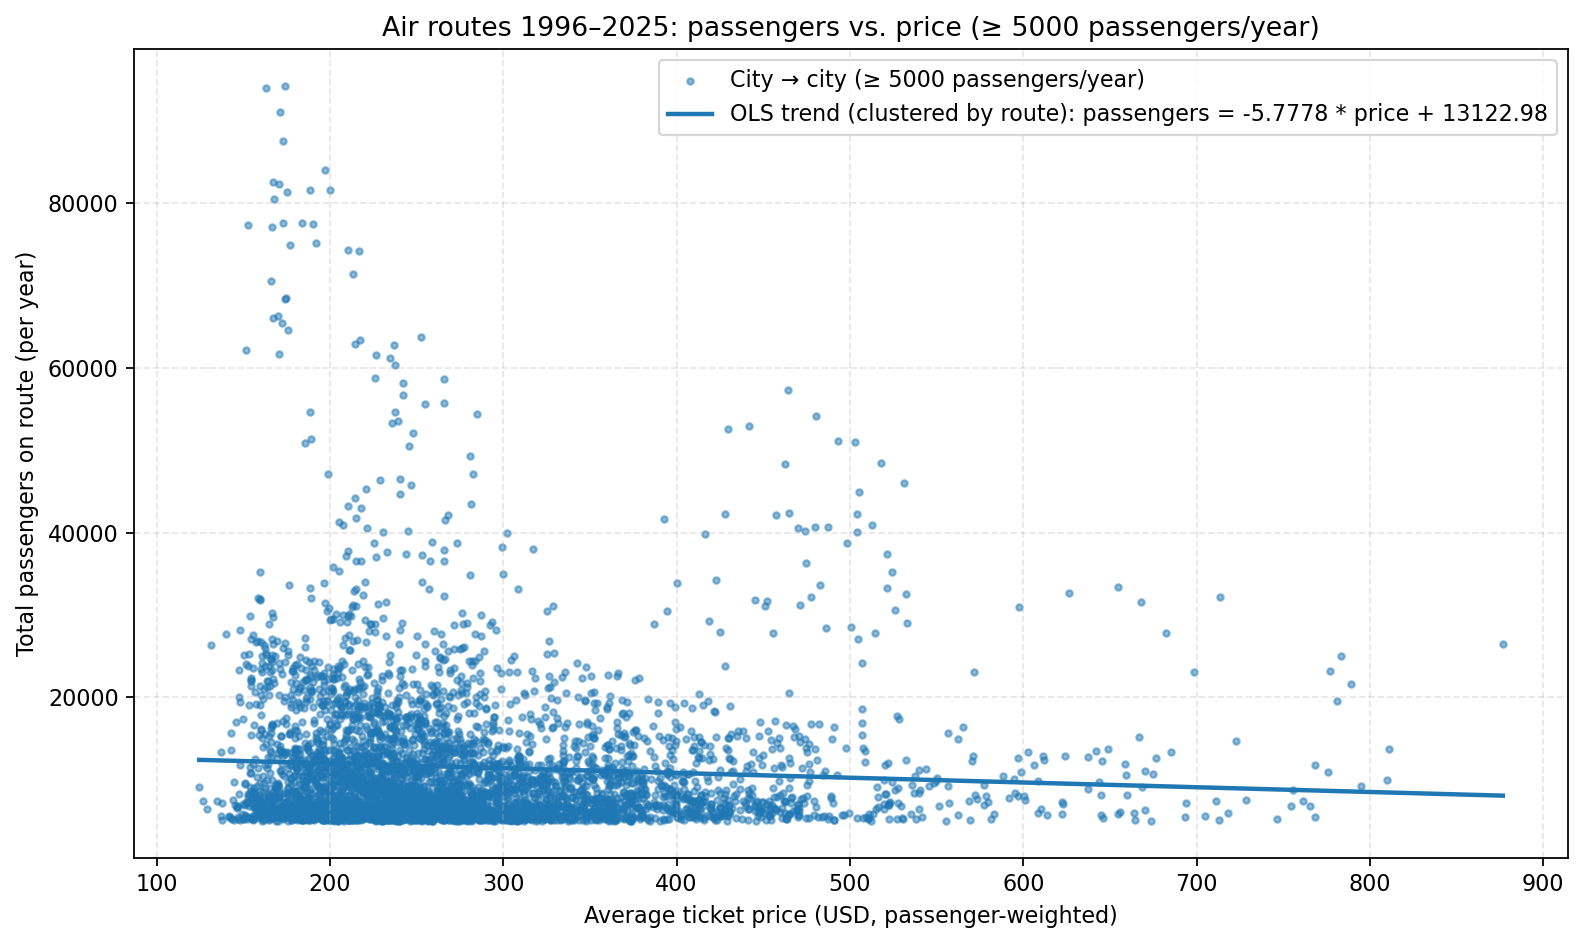

In [51]:
# =========================
# SIMPLE REGRESSION 
# - Display ONLY city->city plot
# - Still saves DAG + states plot + cities plot
# =========================


OUT_DIR = "outputs"
FIG_DIR = os.path.join(OUT_DIR, "figures_simple_reg")


def ensure_dirs():
    os.makedirs(OUT_DIR, exist_ok=True)
    os.makedirs(FIG_DIR, exist_ok=True)


@contextlib.contextmanager
def silence_stdout():
    """
    Mute prints for a block (keeps exceptions visible).
    In Jupyter, this prevents clutter from libraries.
    """
    with open(os.devnull, "w") as devnull:
        with contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
            yield


def make_dag_price_demand():
    """Save DAG (graphviz if possible, else networkx fallback)."""
    ensure_dirs()
    try:
        import graphviz
        if shutil.which("dot") is None:
            raise RuntimeError("Graphviz 'dot' executable not found")

        g = graphviz.Digraph("dag_price_demand", format="png")
        nodes = ["Price", "Passengers", "Distance", "Competition",
                 "MarketSize", "Season", "FuelCost", "AirportFees"]
        for n in nodes:
            g.node(n)
        for z in ["Distance", "Competition", "MarketSize", "Season", "FuelCost", "AirportFees"]:
            g.edge(z, "Price")
            g.edge(z, "Passengers")
        g.edge("Price", "Passengers")

        outbase = os.path.join(FIG_DIR, "dag_price_demand")
        g.render(filename=outbase, cleanup=True)
        return
    except Exception:
        try:
            import networkx as nx

            G = nx.DiGraph()
            Z = ["Distance", "Competition", "MarketSize", "Season", "FuelCost", "AirportFees"]
            G.add_nodes_from(Z + ["Price", "Passengers"])
            for z in Z:
                G.add_edge(z, "Price")
                G.add_edge(z, "Passengers")
            G.add_edge("Price", "Passengers")

            fig = plt.figure(figsize=(7, 5))
            pos = nx.spring_layout(G, seed=1)
            nx.draw_networkx(G, pos, arrows=True, with_labels=True, node_size=1200)
            plt.axis("off")
            plt.tight_layout()

            outpng = os.path.join(FIG_DIR, "dag_price_demand_fallback.png")
            fig.savefig(outpng, dpi=200)
            plt.close(fig)
        except Exception:
            return


def load_and_clean_merged(path=MERGED_CSV) -> pd.DataFrame:
    """
    Load merged_air_travel_data.csv (local path or URL), clean basics.
    """
    df = pd.read_csv(path)

    required = ["passengers", "Real price", "city1", "city2", "Year"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns in merged data: {missing}")

    df = df.copy()
    df["passengers"] = df["passengers"].astype(str).str.replace(",", "", regex=False)
    df["passengers"] = pd.to_numeric(df["passengers"], errors="coerce")
    df["Real price"] = pd.to_numeric(df["Real price"], errors="coerce")
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

    df = df.dropna(subset=["passengers", "Real price", "city1", "city2", "Year"])
    df = df[(df["passengers"] > 0) & (df["Real price"] > 0)]
    df = df[(df["Year"] >= 1996) & (df["Year"] <= 2025)]
    return df


def build_state_city_year_from_df(df: pd.DataFrame) -> pd.DataFrame:
    """Build annual panel: (Year, origin_state, city2) with passenger-weighted avg price."""
    tmp = df.copy()
    tmp["origin_state"] = tmp["city1"].str.extract(r",\s*([A-Z]{2})")[0]
    tmp = tmp.dropna(subset=["Year", "origin_state", "city2", "passengers", "Real price"])

    state_city_year = (
        tmp.groupby(["Year", "origin_state", "city2"])
           .apply(lambda g: pd.Series({
               "total_passengers": g["passengers"].sum(),
               "avg_price": (g["Real price"] * g["passengers"]).sum() / g["passengers"].sum()
           }))
           .reset_index()
    )
    return state_city_year


def plot_states_simple(df_state_city_year: pd.DataFrame):
    """Save only (no show): states -> city scatter + OLS line."""
    ensure_dirs()
    df = df_state_city_year.copy()

    df["total_passengers"] = pd.to_numeric(df["total_passengers"], errors="coerce")
    df["avg_price"] = pd.to_numeric(df["avg_price"], errors="coerce")
    df = df.dropna(subset=["total_passengers", "avg_price"])

    df = df[df["total_passengers"] >= 5000]
    if df.empty:
        return

    df["route_id"] = df["origin_state"].astype(str) + " -> " + df["city2"].astype(str)

    X = add_constant(df["avg_price"])
    y = df["total_passengers"]

    model = sm.OLS(y, X, missing="drop").fit(
        cov_type="cluster",
        cov_kwds={"groups": df["route_id"], "use_correction": True}
    )
    a = model.params.get("avg_price", np.nan)
    b = model.params.get("const", np.nan)

    fig = plt.figure(figsize=(10, 6))
    plt.scatter(df["avg_price"], df["total_passengers"], s=8, alpha=0.5,
                label="State → city (≥ 5000 passengers/year)")

    x = df["avg_price"].values
    if np.isfinite(a) and np.isfinite(b) and x.size >= 2:
        x_line = np.linspace(x.min(), x.max(), 200)
        y_line = a * x_line + b
        plt.plot(x_line, y_line, linewidth=2,
                 label=f"OLS trend (clustered by route): passengers = {a:.4e} * price + {b:.2f}")

    plt.xlabel("Average ticket price (USD, passenger-weighted)")
    plt.ylabel("Total passengers from state to city (per year)")
    plt.title("State-level routes: passengers vs. price (1996–2025)")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()

    outpng = os.path.join(FIG_DIR, "routes_states_price_x.png")
    fig.savefig(outpng, dpi=300)
    plt.close(fig)


def plot_cities_simple(df_merged: pd.DataFrame):
    """Save + show: city -> city scatter + OLS line."""
    ensure_dirs()
    df = df_merged.copy()

    grouped = (
        df.groupby(["Year", "city1", "city2"], as_index=False)
          .apply(lambda g: pd.Series({
              "total_passengers": g["passengers"].sum(),
              "avg_price": (g["Real price"] * g["passengers"]).sum() / g["passengers"].sum()
          }))
          .reset_index(drop=True)
    )

    grouped["total_passengers"] = pd.to_numeric(grouped["total_passengers"], errors="coerce")
    grouped["avg_price"] = pd.to_numeric(grouped["avg_price"], errors="coerce")
    grouped = grouped.replace([np.inf, -np.inf], np.nan).dropna(subset=["avg_price", "total_passengers"])

    grouped = grouped[grouped["total_passengers"] >= 5000]
    if grouped.empty:
        raise ValueError("No city→city observations left after filtering (>=5000 passengers/year).")

    grouped["route_id"] = grouped["city1"].astype(str) + " -> " + grouped["city2"].astype(str)

    X = add_constant(grouped["avg_price"])
    y = grouped["total_passengers"]

    model = sm.OLS(y, X, missing="drop").fit(
        cov_type="cluster",
        cov_kwds={"groups": grouped["route_id"], "use_correction": True}
    )
    a = model.params.get("avg_price", np.nan)
    b = model.params.get("const", np.nan)

    fig = plt.figure(figsize=(10, 6))
    plt.scatter(grouped["avg_price"], grouped["total_passengers"], s=8, alpha=0.5,
                label="City → city (≥ 5000 passengers/year)")

    x = grouped["avg_price"].to_numpy()
    if np.isfinite(a) and np.isfinite(b) and x.size >= 2:
        x_line = np.linspace(x.min(), x.max(), 200)
        y_line = a * x_line + b
        plt.plot(
            x_line, y_line, linewidth=2,
            label=f"OLS trend (clustered by route): passengers = {a:.4f} * price + {b:.2f}"
        )

    plt.xlabel("Average ticket price (USD, passenger-weighted)")
    plt.ylabel("Total passengers on route (per year)")
    plt.title("Air routes 1996–2025: passengers vs. price (≥ 5000 passengers/year)")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(loc="upper right")
    plt.tight_layout()

    outpng = os.path.join(FIG_DIR, "routes_cities_price_x.png")
    fig.savefig(outpng, dpi=300)

    plt.show()     
    plt.close(fig)


# =========================
# RUN (Notebook cell)
# =========================
ensure_dirs()

# Silent block: saves DAG + states plot but no outputs in notebook
with silence_stdout():
    make_dag_price_demand()
    _df = load_and_clean_merged(MERGED_CSV)
    _state_panel = build_state_city_year_from_df(_df)
    plot_states_simple(_state_panel)

# Only display: city plot
_df2 = load_and_clean_merged(MERGED_CSV)
plot_cities_simple(_df2)


## 2.2 Other important variables



### 2.2.1 Confounders

**Route characteristics** (e.g., hub airports, distance, baseline route attractiveness) can influence both ticket pricing and passenger traffic.

**Time-varying aggregate shocks** (e.g., the COVID-19 pandemic) affect prices and demand across all routes at the same time.

**Location-specific shocks** at the origin or destination (e.g., local income changes, tourism booms) may raise both prices and passenger volumes simultaneously.

To address these confounders, we rely on fixed effects. Our specifications include route and year fixed effects, and our richest models additionally use origin–year and destination–year fixed effects (as part of a high-dimensional fixed-effects structure) to absorb time-varying local demand conditions.


### 2.2.2 Additional drivers (not directly observed)

Some relevant drivers of airfares and passenger volumes are not directly observed (or not used as explicit controls) in our dataset, such as fuel costs, airport fees, and broader shifts in environmental awareness. Rather than conditioning on these covariates directly, we use fixed effects to absorb a large share of unobserved heterogeneity and common shocks. Nevertheless, time-varying route-specific shocks that are not captured by our fixed effects may still remain a source of endogeneity.



### 2.2.3 Heterogeneity

- **Route distance (short-haul vs. long-haul)** Route distance is used as a heterogeneity variable since ticket prices are expected to have a stronger effect on passenger demand on short-haul routes, where travelers face closer substitutes such as rail or car travel.

- **Income at the origin** Income at the origin is used as a heterogeneity variable since passengers in lower-income markets are expected to respond more strongly to ticket price changes due to tighter budget constraints.

- **Seasonality (peak vs. off-peak travel)** Seasonality is used as a heterogeneity variable since demand is expected to be less price-sensitive during peak travel periods, when trips are less discretionary and often planned in advance.


# 3. Cleaning the Radar: Preparing the Flight Data 🧹📡





Before we read anything off the radar screen, we have to make sure the instruments aren’t lying.

Airline data are messy by nature. Ticket prices fluctuate constantly, routes enter and exit the market, and a \$200 fare in 1998 is not comparable to a \$200 fare today. So before estimating how fares affect demand, we standardize the evidence and bring everything onto the same runway.
We make three key adjustments:

Real prices: We convert ticket prices into inflation-adjusted dollars so

*   **Real prices**: We convert ticket prices into inflation-adjusted dollars so changes reflect real affordability, not inflation.
*   **Logs**: We work with the logarithm of passenger counts (and prices in the regressions) so results can be read in percentage terms — the natural language of elasticity.

*   **Consistent panels**: We align observations across routes and years and focus on routes with enough repeated activity to avoid noise from tiny, irregular markets.

Finally, we prepare for the main identification strategy: filtering out “background turbulence” with fixed effects. We start with simple route and year filters, and later tighten the radar further with a fully saturated six–fixed-effect design that removes persistent route differences, common shocks, and location-specific booms or slumps.
With the radar calibrated, we can now move from raw correlation to a cleaner view of causality.


# 4. Let the adventure begin - Building the model and clearing the Noise 🏗️
We now have all the tools to begin our investigation. So we start where any analysis should
start: with the simplest possible view of the data.


## 4.1 First signal: a basic OLS - and a lot of noise


Our first step is a basic OLS regression that relates passenger demand to ticket prices across all routes and years. Formally, this can be written as:

$\ln(\text{Passengers}_{odt}) = \beta \ln(\text{Price}_{odt}) + \varepsilon_{odt}$

This regression captures the raw correlation between prices and passengers across all routes and years. The estimated elasticity is small ( −0.11), statistically insignificant, and explains almost none of the variation in passenger demand. This would suggest that air travel demand is highly price-inelastic: even large fare changes would appear to have only a negligible effect on how many people fly.

From the control tower, this is suspicious. The regression compares fundamentally different markets: short hops and long hauls, hubs and regional airports, leisure destinations and business corridors. These persistent differences drown out the true price signal.

At this altitude, we are flying blind.

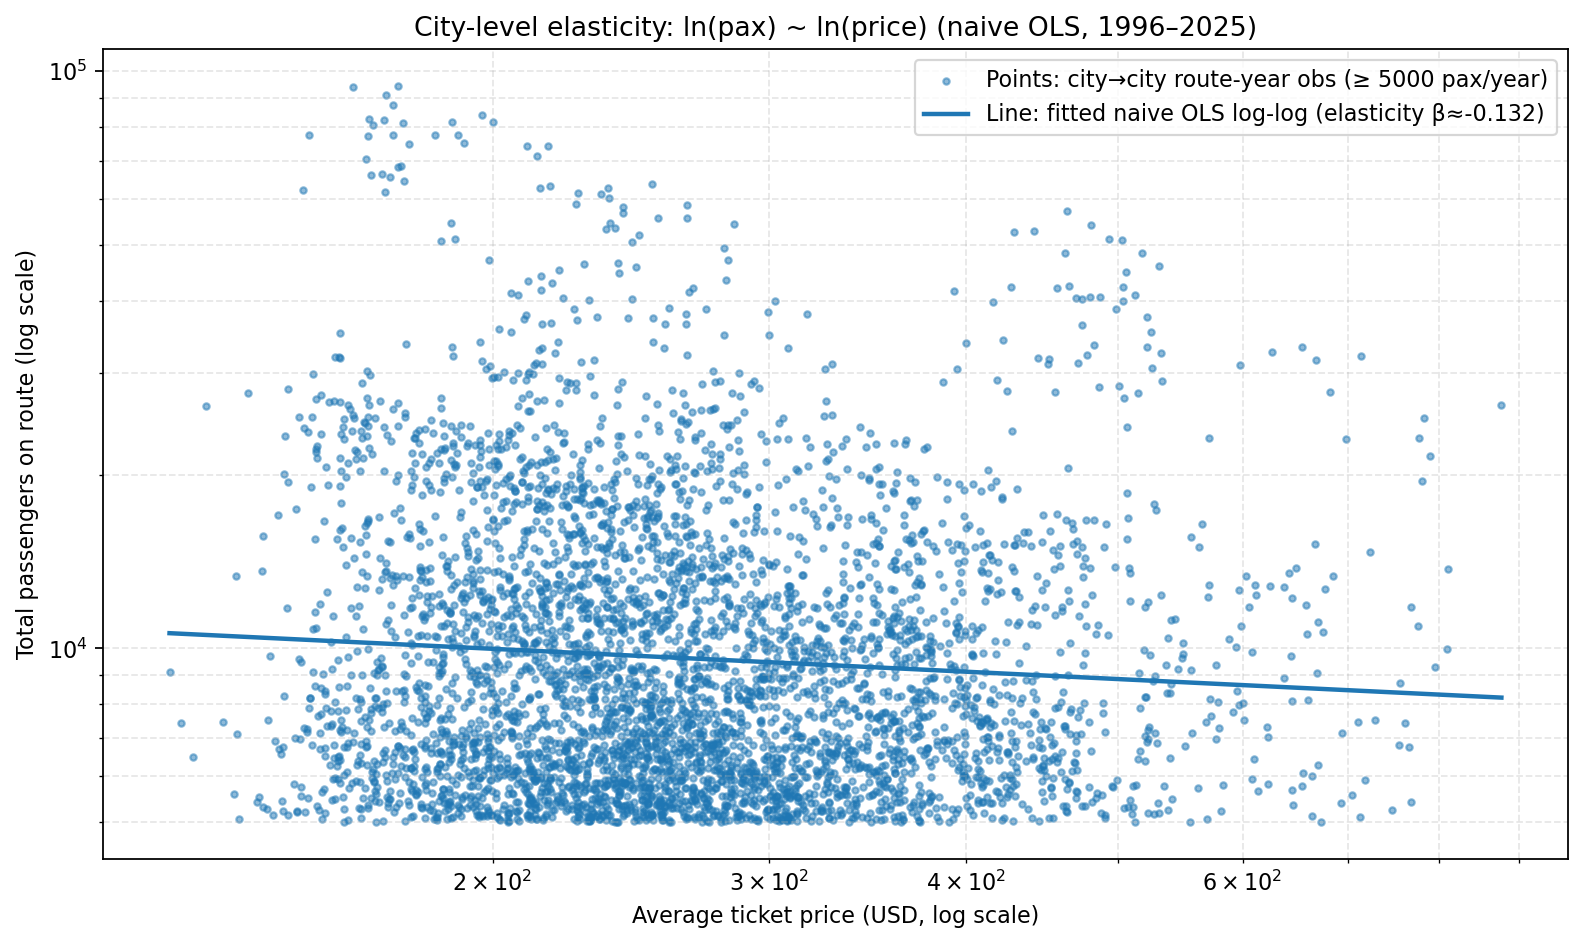

In [52]:
# ============================================================
# elasticity_simple_reg (NOTEBOOK CELL)
# Elasticity = naive OLS log-log (NO FE, NO reverse)
# Input: df already loaded in your first cell
# Display: ONLY city->city plot
# Terminal: no prints
# Files: states plot saved + cities plot saved (outputs/)
# ============================================================

OUTPUT_DIR = "outputs"
MIN_PAX = 5000  # keep your rule

def _ensure_out_dir():
    os.makedirs(OUTPUT_DIR, exist_ok=True)

@contextlib.contextmanager
def silence_output():
    with open(os.devnull, "w") as devnull:
        with contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
            yield

def _clean_merged_from_df(df_in: pd.DataFrame) -> pd.DataFrame:
    d = df_in.copy()

    d["passengers"] = d["passengers"].astype(str).str.replace(",", "", regex=False)
    d["passengers"] = pd.to_numeric(d["passengers"], errors="coerce")

    d["Real price"] = pd.to_numeric(d["Real price"], errors="coerce")
    d["Year"] = pd.to_numeric(d["Year"], errors="coerce")

    d = d.dropna(subset=["passengers", "Real price", "Year", "city1", "city2"])
    d = d[(d["passengers"] > 0) & (d["Real price"] > 0)]
    d = d[(d["Year"] >= 1996) & (d["Year"] <= 2025)]
    return d

def build_state_city_year_from_merged(df_merged: pd.DataFrame) -> pd.DataFrame:
    s = df_merged.copy()
    s["origin_state"] = s["city1"].astype(str).str.extract(r",\s*([A-Z]{2})")[0]
    s = s.dropna(subset=["Year", "origin_state", "city2", "passengers", "Real price"])

    state_city_year = (
        s.groupby(["Year", "origin_state", "city2"])
         .apply(lambda g: pd.Series({
             "total_passengers": g["passengers"].sum(),
             "avg_price": (g["Real price"] * g["passengers"]).sum() / g["passengers"].sum()
         }))
         .reset_index()
    )
    return state_city_year

def plot_states_elasticity_saved_only(state_df: pd.DataFrame, min_pax=MIN_PAX):
    _ensure_out_dir()
    d = state_df.copy()

    d["total_passengers"] = pd.to_numeric(d["total_passengers"], errors="coerce")
    d["avg_price"] = pd.to_numeric(d["avg_price"], errors="coerce")
    d = d.dropna(subset=["total_passengers", "avg_price"])
    d = d[(d["total_passengers"] > 0) & (d["avg_price"] > 0)]
    d = d[d["total_passengers"] >= min_pax]
    if d.empty:
        return None

    d["ln_pax"] = np.log(d["total_passengers"])
    d["ln_price"] = np.log(d["avg_price"])
    d["route_id"] = d["origin_state"].astype(str) + " -> " + d["city2"].astype(str)

    X = add_constant(d[["ln_price"]])
    res = sm.OLS(d["ln_pax"], X, missing="drop").fit(
        cov_type="cluster",
        cov_kwds={"groups": d["route_id"], "use_correction": True}
    )

    beta = float(res.params.get("ln_price", np.nan))
    alpha = float(res.params.get("const", np.nan))

    x = d["avg_price"].to_numpy()
    y = d["total_passengers"].to_numpy()
    x_line = np.logspace(np.log10(x.min()), np.log10(x.max()), 200)
    y_line = np.exp(alpha) * (x_line ** beta)

    plt.figure(figsize=(10, 6))
    plt.scatter(
        x, y, s=8, alpha=0.5,
        label=f"Points: state→city route-year obs (≥ {min_pax} pax/year)"
    )
    plt.plot(
        x_line, y_line, linewidth=2,
        label=f"Line: fitted naive OLS log-log (elasticity β≈{beta:.3f})"
    )
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("Average ticket price (USD, log scale)")
    plt.ylabel("Total passengers (log scale)")
    plt.title("State-level elasticity: ln(pax) ~ ln(price) (naive OLS, 1996–2025)")
    plt.grid(True, which="both", linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()

    outpath = os.path.join(OUTPUT_DIR, "routes_states_loglog_price_x.png")
    plt.savefig(outpath, dpi=300)
    plt.close()
    return res

def plot_cities_elasticity_show_only(df_merged: pd.DataFrame, min_pax=MIN_PAX):
    _ensure_out_dir()
    d = df_merged.copy()

    grouped = (
        d.groupby(["Year", "city1", "city2"], as_index=False)
         .apply(lambda g: pd.Series({
             "total_passengers": g["passengers"].sum(),
             "avg_price": (g["Real price"] * g["passengers"]).sum() / g["passengers"].sum()
         }))
         .reset_index(drop=True)
    )

    grouped["total_passengers"] = pd.to_numeric(grouped["total_passengers"], errors="coerce")
    grouped["avg_price"] = pd.to_numeric(grouped["avg_price"], errors="coerce")
    grouped = grouped.replace([np.inf, -np.inf], np.nan).dropna(subset=["avg_price", "total_passengers"])
    grouped = grouped[(grouped["total_passengers"] > 0) & (grouped["avg_price"] > 0)]
    grouped = grouped[grouped["total_passengers"] >= min_pax].copy()
    if grouped.empty:
        raise ValueError(f"[CITIES] No routes with total_passengers >= {min_pax} after cleaning.")

    grouped["ln_pax"] = np.log(grouped["total_passengers"])
    grouped["ln_price"] = np.log(grouped["avg_price"])
    grouped["route_id"] = grouped["city1"].astype(str) + " -> " + grouped["city2"].astype(str)

    X = add_constant(grouped[["ln_price"]])
    res = sm.OLS(grouped["ln_pax"], X, missing="drop").fit(
        cov_type="cluster",
        cov_kwds={"groups": grouped["route_id"], "use_correction": True}
    )

    beta = float(res.params.get("ln_price", np.nan))
    alpha = float(res.params.get("const", np.nan))

    x = grouped["avg_price"].to_numpy()
    y = grouped["total_passengers"].to_numpy()
    x_line = np.logspace(np.log10(x.min()), np.log10(x.max()), 200)
    y_line = np.exp(alpha) * (x_line ** beta)

    plt.figure(figsize=(10, 6))
    plt.scatter(
        x, y, s=8, alpha=0.5,
        label=f"Points: city→city route-year obs (≥ {min_pax} pax/year)"
    )
    plt.plot(
        x_line, y_line, linewidth=2,
        label=f"Line: fitted naive OLS log-log (elasticity β≈{beta:.3f})"
    )
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("Average ticket price (USD, log scale)")
    plt.ylabel("Total passengers on route (log scale)")
    plt.title("City-level elasticity: ln(pax) ~ ln(price) (naive OLS, 1996–2025)")
    plt.grid(True, which="both", linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()

    outpath = os.path.join(OUTPUT_DIR, "routes_cities_loglog_price_x.png")
    plt.savefig(outpath, dpi=300)
    plt.show()
    plt.close()
    return res

# -------------------------
# RUN (silent except 1 plot)
# -------------------------
with silence_output():
    df_merged = _clean_merged_from_df(df)
    state_panel = build_state_city_year_from_merged(df_merged)
    _ = plot_states_elasticity_saved_only(state_panel, min_pax=MIN_PAX)

# ONLY DISPLAYED OUTCOME:
ols_city_res = plot_cities_elasticity_show_only(df_merged, min_pax=MIN_PAX)


## 4.2 Second signal: OLS with route and year fixed effects


Instead of comparing different routes to one another, we now compare each route to itself
over time. This is done by adding route and year fixed effects:

$$
\ln(\text{Passengers}_{odt})
=
\beta \ln(\text{Price}_{odt})
+
\alpha_{od}
+
\alpha_t
+
\varepsilon_{odt}$$



*  **Route fixed effects (αod)** control for all time-invariant characteristics of an origin– destination pair, most importantly distance. Distance affects prices through fuel and operating costs and affects demand through travel time and convenience. Failing to absorb it would bias the estimated price elasticity.
*   **Year fixed effects (αt)** remove shocks common to all routes in a given year, such as fuel price changes, macroeconomic conditions, technological progress in aviation, and major disruptions like COVID-19.

 Once these filters are in place, the picture changes dramatically. The estimated elasticity jumps to −0.66, becomes highly statistically significant, and the model now explains a meaningful share of within-route variation. This tells us something important: cross-sectional OLS was understating price sensitivity because it compared fundamentally different markets.




/var/folders/51/3n25y_z52gv5pl9nc6jn4q440000gn/T/ipykernel_94635/1783848222.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = float(res.params[1])  # coefficient on x_tilde


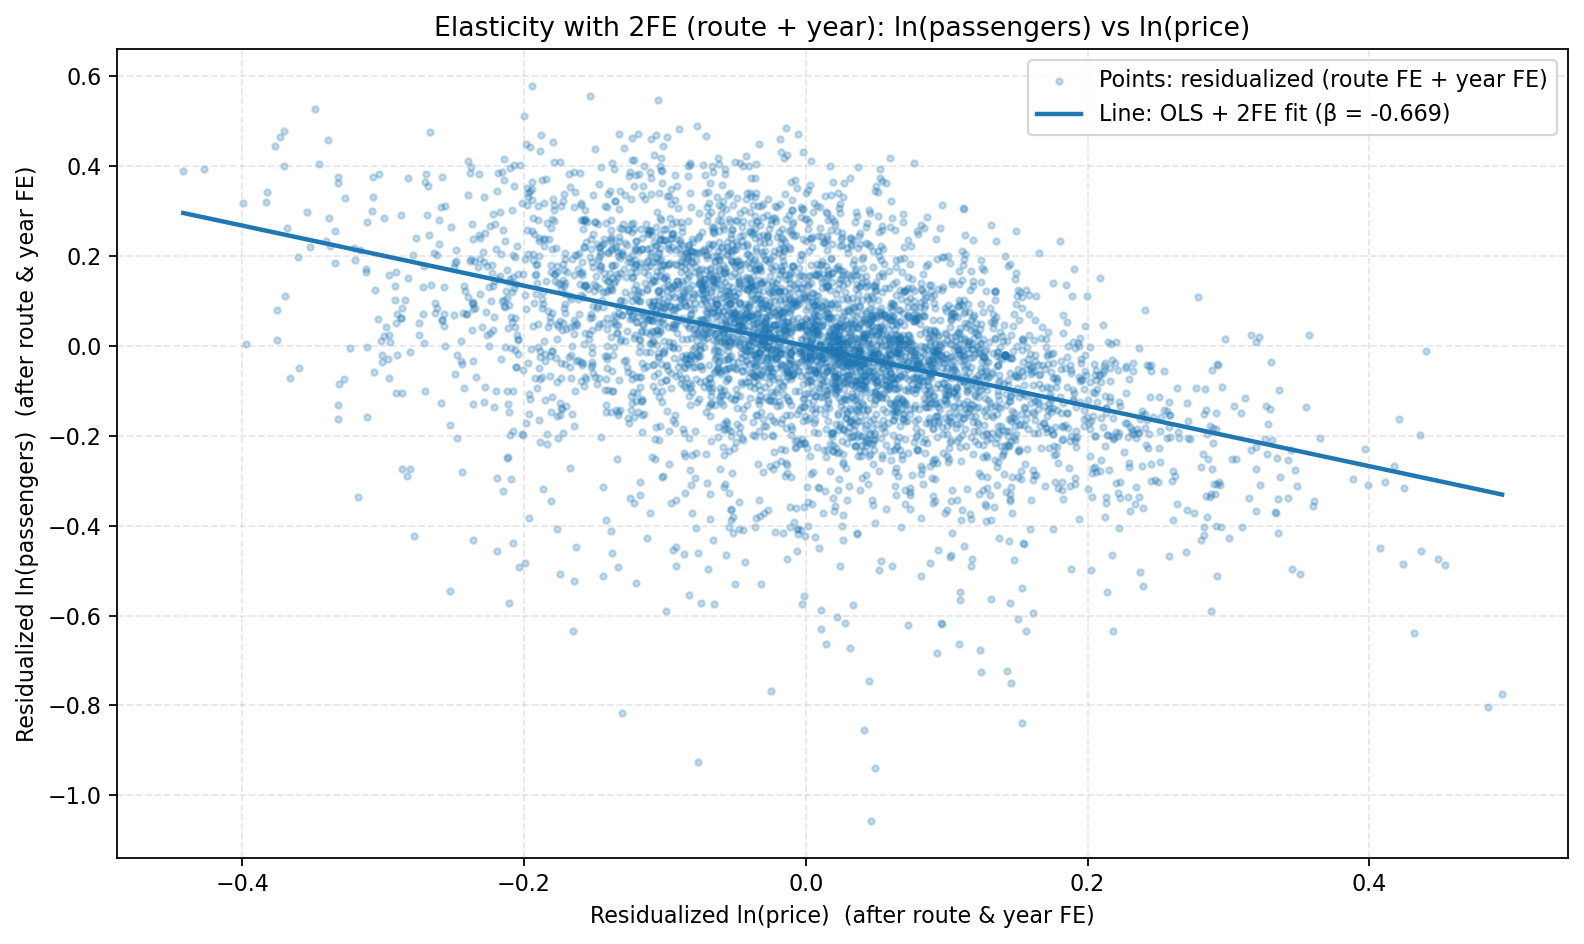

In [54]:
# ============================================================
# Plot: OLS + 2FE (route + year) — city->city elasticity (log-log)
# Displays ONLY the plot (no prints). Saves figure to outputs/.
# ============================================================

# ---------- Build annual route-year panel ----------
d = df.copy()
d["passengers"] = pd.to_numeric(d["passengers"].astype(str).str.replace(",", "", regex=False), errors="coerce")
d["Real price"] = pd.to_numeric(d["Real price"], errors="coerce")
d["Year"] = pd.to_numeric(d["Year"], errors="coerce")

d = d.dropna(subset=["Year", "city1", "city2", "passengers", "Real price"])
d = d[(d["passengers"] > 0) & (d["Real price"] > 0)]
d = d[(d["Year"] >= 1996) & (d["Year"] <= 2025)]

g = (
    d.groupby(["Year", "city1", "city2"], as_index=False)
     .apply(lambda x: pd.Series({
         "total_passengers": x["passengers"].sum(),
         "avg_price": (x["Real price"] * x["passengers"]).sum() / x["passengers"].sum()
     }))
     .reset_index(drop=True)
)

g = g[g["total_passengers"] >= 5000].copy()
g = g.replace([np.inf, -np.inf], np.nan).dropna(subset=["avg_price", "total_passengers"])

g["ln_pax"] = np.log(g["total_passengers"])
g["ln_price"] = np.log(g["avg_price"])
g["route_id"] = g["city1"].astype(str) + " -> " + g["city2"].astype(str)

if g.empty:
    raise ValueError("No observations left after cleaning/aggregation (check filters).")

# ---------- Two-way demeaning (route FE + year FE) ----------
def two_way_demean(series, route, year):
    overall = series.mean()
    route_mean = series.groupby(route).transform("mean")
    year_mean  = series.groupby(year).transform("mean")
    return series - route_mean - year_mean + overall

x_tilde = two_way_demean(g["ln_price"], g["route_id"], g["Year"])
y_tilde = two_way_demean(g["ln_pax"],   g["route_id"], g["Year"])

# ---------- Estimate slope (OLS on residualized vars), clustered by route ----------
X = sm.add_constant(x_tilde)
res = sm.OLS(y_tilde, X, missing="drop").fit(
    cov_type="cluster",
    cov_kwds={"groups": g["route_id"], "use_correction": True}
)
beta = float(res.params[1])  # coefficient on x_tilde

# ---------- Plot residualized relationship (this corresponds to OLS + 2FE) ----------
os.makedirs("outputs", exist_ok=True)

x = x_tilde.to_numpy()
y = y_tilde.to_numpy()

# fitted line in residual space
x_line = np.linspace(np.nanmin(x), np.nanmax(x), 200)
y_line = beta * x_line  # intercept ~ 0 in residual space

plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=8, alpha=0.25, label="Points: residualized (route FE + year FE)")
plt.plot(x_line, y_line, linewidth=2, label=f"Line: OLS + 2FE fit (β = {beta:.3f})")

plt.xlabel("Residualized ln(price)  (after route & year FE)")
plt.ylabel("Residualized ln(passengers)  (after route & year FE)")
plt.title("Elasticity with 2FE (route + year): ln(passengers) vs ln(price)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()

outpath = os.path.join("outputs", "cities_OLS_2FE_residual_plot.png")
plt.savefig(outpath, dpi=300)
plt.show()
plt.close()


## 4.3 Third signal: a fully saturated model fixed effects
But some shocks are neither purely route-specific nor purely global. Local economic booms, tourism surges, housing crises, or destination-specific demand shifts can affect ticket prices and passenger volumes at the same time. If we ignore these local dynamics, we risk attributing their effects to prices.

To absorb these remaining sources of noise, we estimate a fully saturated fixed-effects
model:

$$
\ln(\text{Passengers}_{odt})
=
\beta \ln(\text{Price}_{odt})
+
\alpha_o
+
\alpha_d
+
\alpha_t
+
\alpha_{od}
+
\alpha_{ot}
+
\alpha_{dt}
+
\varepsilon_{odt}$$


Each fixed effect plays a specific role in filtering the radar:

* **Origin fixed effects (αo)** control for time-invariant characteristics of origin locations,
such as population size, income levels, airport capacity, or a general culture of flying.

* **Destination fixed effects (αd)** absorb persistent destination attractiveness, including
tourism appeal, climate, business activity, and long-run demand for travel to specific
places.


* **Origin–year fixed effects (αot)** capture shocks that affect a specific origin in a given
year, such as local income changes, housing market dynamics, or shifts in environmental
awareness that influence travel behavior.


* **Destination–year fixed effects (αdt)** absorb shocks specific to destinations in a
given year, including tourism booms or busts, local policy changes, or destination-
specific demand surges.


In this most restrictive model, the elasticity stabilizes −0.77, with very tight confidence intervals and strong statistical significance. Importantly, this estimate remains very close to the result obtained with route and year fixed effects alone, indicating that the relationship is not driven by omitted route-specific or location-specific trends.

Seen together, the sequence of regressions tells a clear story. In the raw OLS, the price signal is obscured by large differences across routes. As we add fixed effects and compare each route to itself over time, the signal sharpens. Once persistent route characteristics and common shocks are filtered out, passenger demand is substantially more responsive to prices than raw correlations suggest.




## 4.4 Final Turbulence Check: Reverse Causality on the Radar

One remaining concern is reverse causality. Airlines do not set prices in a vacuum: when a route becomes popular, higher demand can itself push prices up through yield management and capacity constraints. In that case, a simple regression of passengers on prices risks confusing cause and effect.
To reduce this problem, we shift the timing of the analysis. Instead of relating passenger demand to current prices, we examine how last year’s ticket prices affect this year’s passenger volumes on the same route. Current demand cannot mechanically influence past prices, which helps isolate the direction we care about: prices → demand.

$$\
\ln(\text{Passengers}_{odt})
=
\beta \ln(\text{Price}_{od,t-1})
+ \alpha_o + \alpha_d + \alpha_t
+ \alpha_{od} + \alpha_{ot} + \alpha_{dt} +
\varepsilon_{odt}$$



The data reveal a clear pattern. Across both city–city and state–city panels, higher prices in year t–1 are followed by significantly lower passenger volumes in year t. Once we control for route characteristics and time-varying origin and destination shocks, a 1% increase in last year’s price reduces next year’s passenger traffic by roughly 0.7–1%, depending on the level of aggregation. The fact that this effect remains strong and stable after introducing lagged prices suggests that the negative price–demand relationship is not driven by demand pushing prices up, but by higher prices actively discouraging future travel.




[INFO] Chargement de /Users/oceanecarrillo/Documents/SMT E4S/Data Science/Project_Notebook/data/merged_air_travel_data.csv ...
[INFO] Données nettoyées: 118035 lignes.

[INFO] Loading quarterly city-level data from /Users/oceanecarrillo/Documents/SMT E4S/Data Science/Project_Notebook/data/merged_air_travel_data.csv ...

[INFO] Aggregating to annual level (city1, city2, Year) ...

[INFO] City panel ready: 27305 observations with lagged price available.
[INFO] Saved CSV: /Users/oceanecarrillo/Documents/SMT E4S/Data Science/Project_Notebook/outputs/spec_curve_city_to_city_6specs.csv


<Figure size 640x480 with 0 Axes>

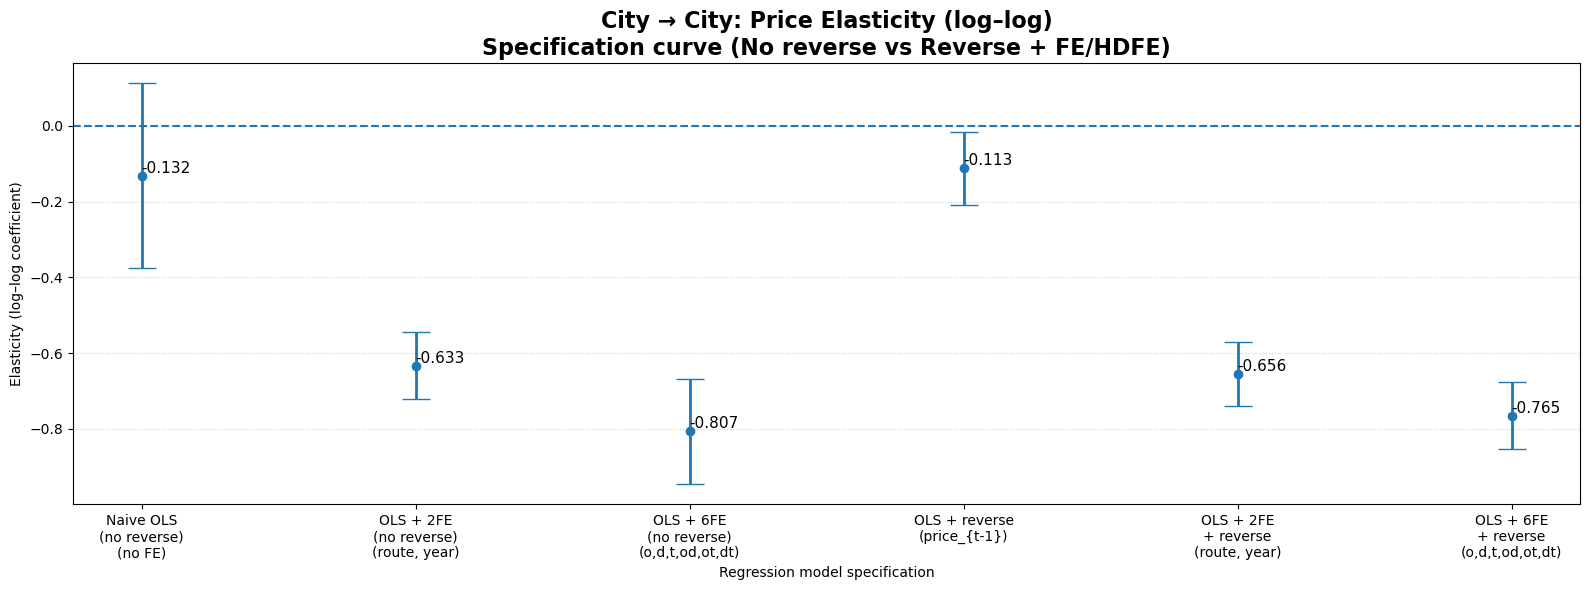

[INFO] Saved figure: /Users/oceanecarrillo/Documents/SMT E4S/Data Science/Project_Notebook/outputs/figures_spec_curve/SpecCurve_City_to_City_6specs.png


<Figure size 640x480 with 0 Axes>

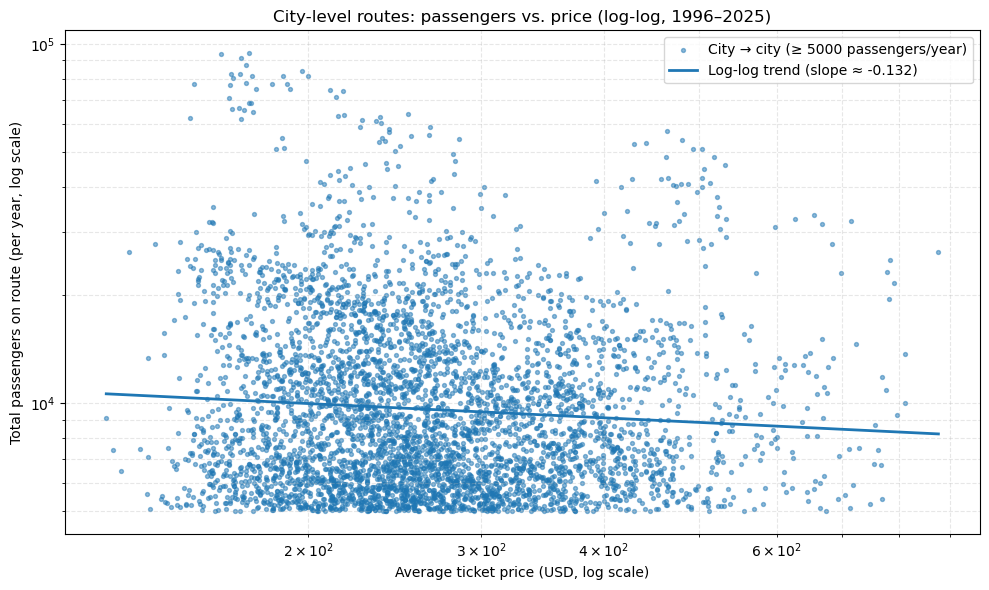

In [38]:
from pathlib import Path
print("CWD:", Path.cwd())
print("Exists?", (Path("scr")/"endogeneity_from_merged.py").exists())
print("Files in scr:", [p.name for p in Path("scr").glob("*.py")])


CWD: /Users/oceanecarrillo/Documents/SMT E4S/Data Science/Project_Notebook
Exists? False
Files in scr: ['elasticity_reg_w_FE.py', 'Reverse_causality.py', 'Reverse_Causality_spec_curve.py', 'Litterature_technics_tax.py', 'Data_cleaning.py', 'Reverse_Causality _w_FE.py', 'endogeneity.py', 'elasticity_simple_reg.py', 'States_advanced_causal.py', 'simple_regression.py']


<Figure size 640x480 with 0 Axes>

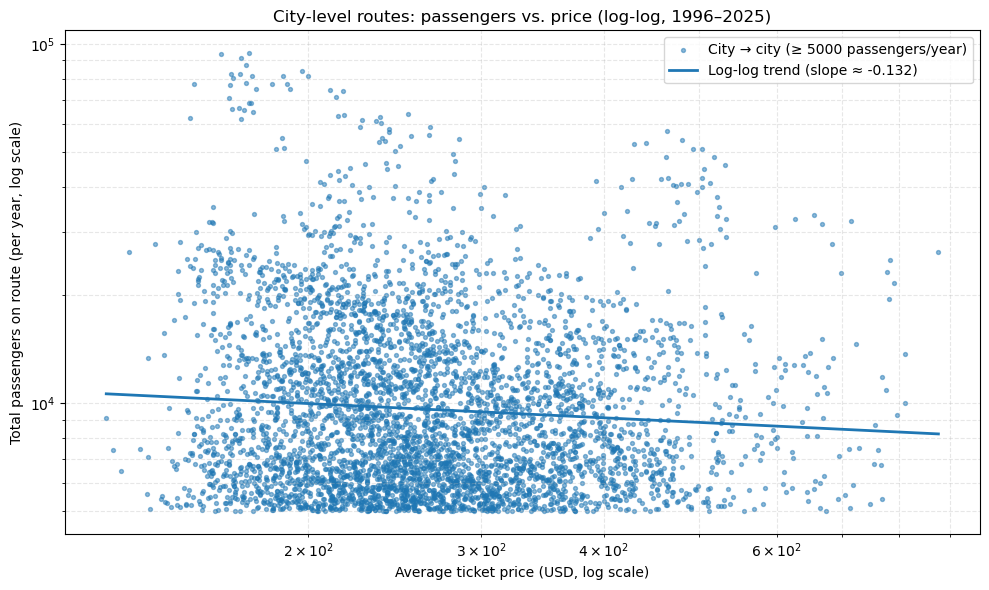

<Figure size 640x480 with 0 Axes>

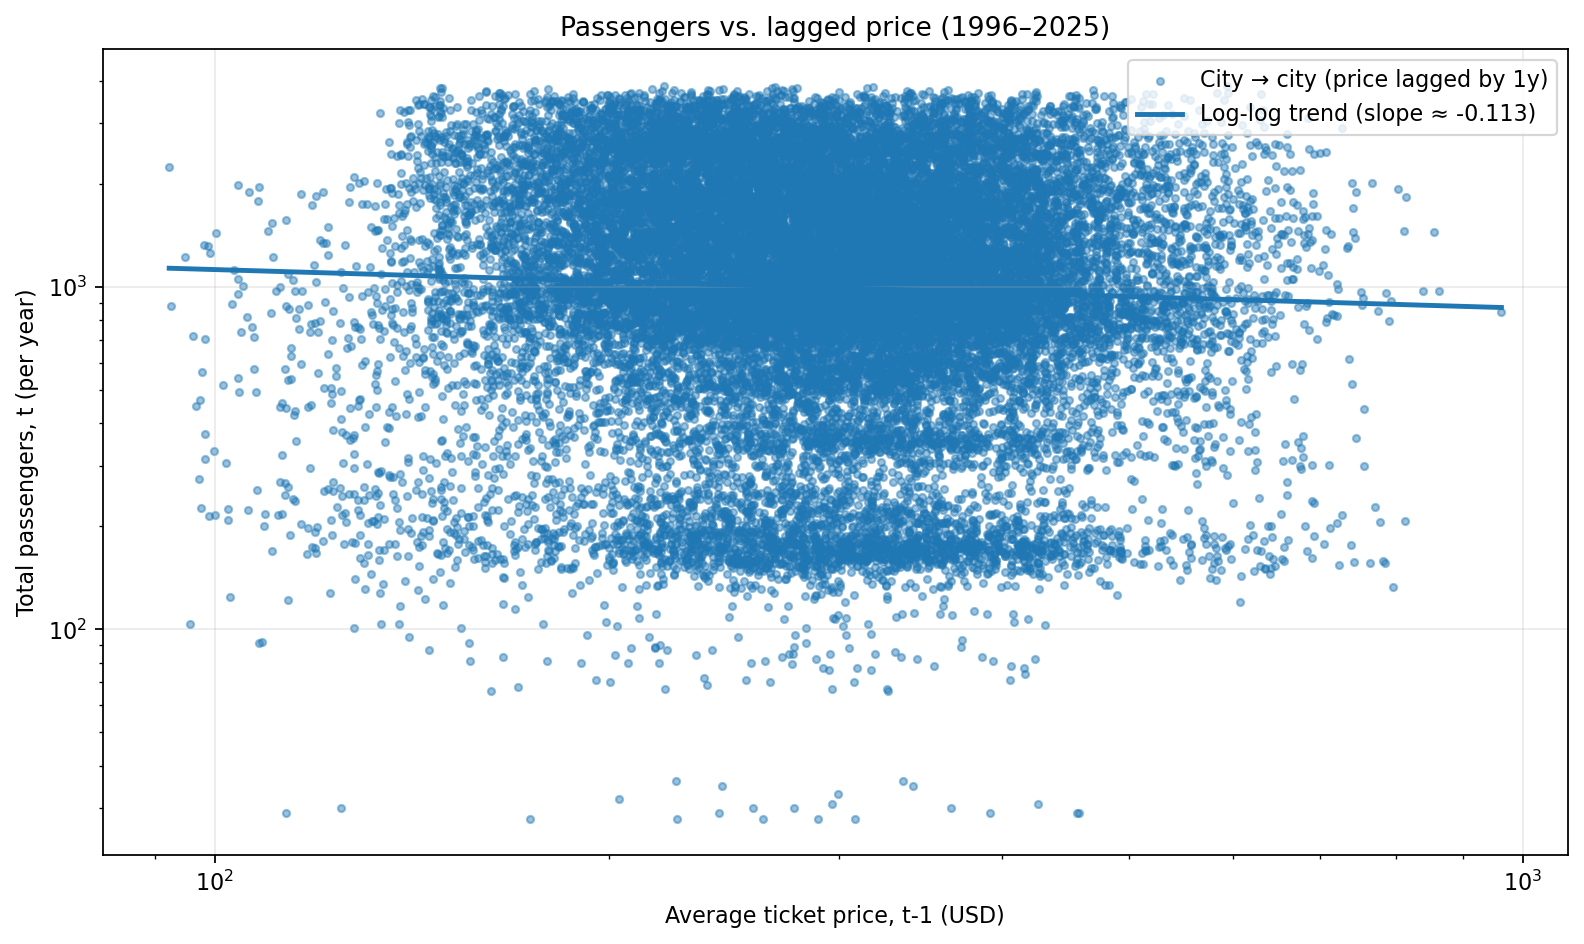


Passenger-weighted distance groups summary:
   dist_group  n_routes   pax_total  km_min  km_max
0           0       242  15715462.0     189     712
1           1       313  15787958.0     713    1110
2           2       290  15321117.0    1114    1522
3           3       257  16211539.0    1522    1859
4           4       306  15481843.0    1860    2816
5           5       238  16048469.0    2817    4384


<Figure size 640x480 with 0 Axes>

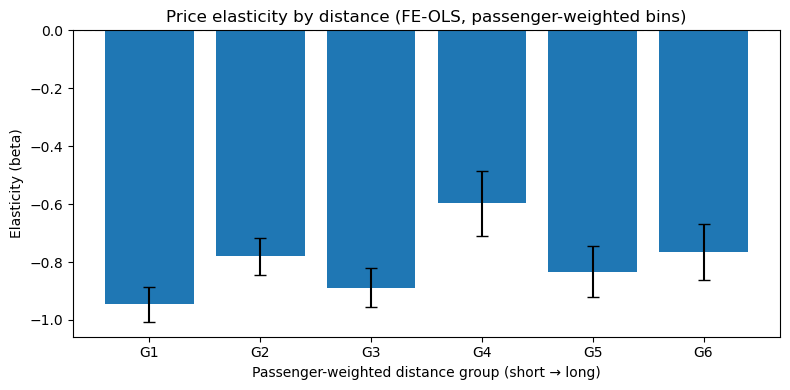